In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
import time

color_pal = sns.color_palette()

## Read in data and engineer features

In [149]:
#read input data
df_input = pd.read_csv('data/Netherlands/input_data.csv')

In [150]:
df_input

time   rr         tg     tn     tx          pp         hu    fg  \
0      1990-01-01  0.0  -1.710000  -2.45  -1.64  1020.60004  93.062500  2.32   
1      1990-01-02  0.0  -0.660000  -2.29  -0.24  1022.30000  92.053340  2.13   
2      1990-01-03  0.0   0.050000  -0.62   0.69  1024.10000  91.489480  3.79   
3      1990-01-04  2.5  -0.290000  -1.86   1.44  1021.60004  93.492860  3.91   
4      1990-01-05  0.0   3.210000   1.35   3.84  1023.60004  93.287340  3.72   
...           ...  ...        ...    ...    ...         ...        ...   ...   
11683  2021-12-27  0.0   2.110000  -0.07   5.08   998.70000  92.220000  3.13   
11684  2021-12-28  5.5   6.610000   3.88   7.97   990.40000  93.700005  3.36   
11685  2021-12-29  4.0   7.030000   5.49  10.78  1001.30000  93.700005  2.99   
11686  2021-12-30  4.4  11.370000   9.20  13.02  1013.10004  92.500010  3.85   
11687  2021-12-31  9.1  12.799999  11.41  12.79  1018.40000  86.878950  3.85   

         qq        et  
0       9.0  0.074566  
1      11.0  0.095090  
2      12.0  0.106630  
3      10.0  0.087787  
4       8.0  0.080110  
...     ...       ...  
11683  20.0  0.195135  
11684  23.0  0.262438  
11685  21.0  0.241433  
11686  18.0  0.232722  
11687  21.0  0.280901  

[11688 rows x 10 columns]

In [118]:
#read heads data
df_y = pd.read_csv('data/Netherlands/heads.csv')

df_y.rename(columns = {'Unnamed: 0':'time'}, inplace=True)
df_y.head()

time   head
0  2000-01-01  11.24
1  2000-01-02  11.24
2  2000-01-03  11.23
3  2000-01-04  11.26
4  2000-01-05  11.24

In [151]:
# create lag features (mean values over the past 15, 30 and 90 days)

for j in ['rr','tg','tn','tx','pp','hu','fg','qq','et']:
    temps = pd.DataFrame(df_input[j].values)
    shifted = temps.shift(1)
    for k in [15,30,90]:
        window, means, mins, maxs = {}, {}, {}, {}
        window["{}".format(k)] = shifted.rolling(window=k)
        means["{}".format(k)] = window["{}".format(k)].mean()
        df_input["{}_avg_{}".format(j,k)]=means["{}".format(k)].to_numpy()     

# drop missing values after creating lag features
df_input.dropna(inplace = True)
print(df_input.shape)
df_input.head()

(11598, 37)


time   rr         tg    tn         tx      pp         hu    fg  \
90  1990-04-01  0.0  11.679999  4.41  19.810000  1021.2  77.020004  2.63   
91  1990-04-02  2.8  12.660000  6.41  19.830000  1002.9  68.780000  5.17   
92  1990-04-03  2.9   6.430000  1.91   9.929999   999.3  80.690000  6.66   
93  1990-04-04  1.6   3.280000 -1.10   7.580000  1012.7  81.275000  4.97   
94  1990-04-05  0.0   2.560000 -2.51   7.770000  1019.8  80.490000  2.10   

       qq        et  ...  hu_avg_90  fg_avg_15  fg_avg_30  fg_avg_90  \
90  202.0  2.623742  ...  86.530844   4.604667   5.527000   6.109555   
91  180.0  2.414609  ...  86.352594   4.600667   5.415333   6.113000   
92  118.0  1.332945  ...  86.094001   4.740000   5.391333   6.146778   
93  158.0  1.595542  ...  85.974007   4.779333   5.348000   6.178667   
94  183.0  1.793791  ...  85.838253   4.850667   5.184333   6.190444   

     qq_avg_15   qq_avg_30  qq_avg_90  et_avg_15  et_avg_30  et_avg_90  
90  123.533333  103.666667  57.300000   1.443475   1.197066   0.654154  
91  126.200000  107.133333  59.444444   1.482732   1.252935   0.682478  
92  127.133333  110.300000  61.322222   1.498433   1.303450   0.708251  
93  130.133333  112.600000  62.500000   1.523412   1.329318   0.721876  
94  132.000000  116.766667  64.144444   1.525781   1.369730   0.738629  

[5 rows x 37 columns]

In [134]:
# merge input and heads data
df_merged = pd.merge(df_input,df_y,on='time',how='outer')
df_merged = df_merged.set_index('time')
df_merged.index = pd.to_datetime(df_merged.index)
df_merged.index = df_merged.index.rename("time")
df_merged.dropna(inplace = True)

In [135]:
df_X = df_merged.drop(columns=['head'])

In [136]:
df_X

rr         tg     tn         tx          pp         hu  \
time                                                                        
2000-01-01   0.000000   4.110000   0.96   8.510000  1022.80000  94.596300   
2000-01-02   0.000000   6.150000   3.23   8.000000  1025.70010  93.992600   
2000-01-03  14.900001   8.160000   5.32   9.150000  1018.20000  93.388890   
2000-01-04   3.600000   4.810000   2.24   8.580000  1013.30000  94.700005   
2000-01-05   0.000000   3.960000   1.81   5.510000  1017.60004  90.840004   
...               ...        ...    ...        ...         ...        ...   
2015-09-06   6.700000  12.750000   9.83  17.109999  1020.90000  84.055000   
2015-09-07   2.600000  14.299999  12.09  18.070000  1024.90000  90.160000   
2015-09-08   0.000000  13.469999   8.46  17.100000  1025.70010  88.535000   
2015-09-09   0.000000  12.400000   6.78  17.960000  1025.20010  81.855000   
2015-09-10   0.000000  12.670000   6.95  18.710000  1024.50000  83.735000   

              fg     qq        et  rr_avg_15  ...  hu_avg_90  fg_avg_15  \
time                                          ...                         
2000-01-01  3.38   14.0  0.144754   4.153333  ...  89.189862   5.122000   
2000-01-02  4.33   10.0  0.110497   3.766667  ...  89.241166   4.784000   
2000-01-03  6.76    8.0  0.094391   3.566667  ...  89.309028   4.808667   
2000-01-04  4.12   10.0  0.106417   4.046667  ...  89.405460   5.006667   
2000-01-05  4.78   36.0  0.371323   4.286667  ...  89.477071   5.050667   
...          ...    ...       ...        ...  ...        ...        ...   
2015-09-06  5.28  133.0  1.775053   6.393333  ...  80.487582   3.989333   
2015-09-07  3.55  134.0  1.853177   6.840000  ...  80.603193   4.145333   
2015-09-08  2.48  111.0  1.504789   6.753333  ...  80.788527   4.045333   
2015-09-09  2.91  186.0  2.456554   5.753333  ...  80.970971   3.994667   
2015-09-10  3.14  188.0  2.500485   5.600000  ...  81.075249   3.809333   

            fg_avg_30  fg_avg_90   qq_avg_15   qq_avg_30   qq_avg_90  \
time                                                                   
2000-01-01   5.887333   4.846555   18.266667   18.866667   39.955556   
2000-01-02   5.740667   4.817222   18.866667   18.466667   39.233333   
2000-01-03   5.515000   4.823889   17.733333   18.500000   38.377778   
2000-01-04   5.528667   4.857555   16.400000   17.766667   37.333333   
2000-01-05   5.522000   4.865555   14.866667   16.866667   36.555556   
...               ...        ...         ...         ...         ...   
2015-09-06   3.296333   3.429222  151.466667  156.000000  194.544444   
2015-09-07   3.408000   3.444222  143.866667  153.266667  193.077778   
2015-09-08   3.416667   3.439667  137.200000  151.566667  192.355556   
2015-09-09   3.450667   3.421889  135.400000  147.066667  190.144444   
2015-09-10   3.503333   3.409000  137.800000  148.966667  188.522222   

            et_avg_15  et_avg_30  et_avg_90  
time                                         
2000-01-01   0.177222   0.191779   0.460777  
2000-01-02   0.183295   0.187007   0.451380  
2000-01-03   0.173720   0.187269   0.440369  
2000-01-04   0.163354   0.180195   0.427418  
2000-01-05   0.150373   0.171451   0.417583  
...               ...        ...        ...  
2015-09-06   2.215745   2.316546   2.857772  
2015-09-07   2.078968   2.264558   2.839823  
2015-09-08   1.960444   2.236029   2.832018  
2015-09-09   1.922162   2.164954   2.801076  
2015-09-10   1.940008   2.181599   2.776157  

[5696 rows x 36 columns]

In [96]:
df_y = pd.DataFrame(df_merged['head'])
df_y.index = pd.to_datetime(df_y.index)

head
time             
2000-01-01  11.24
2000-01-02  11.24
2000-01-03  11.23
2000-01-04  11.26
2000-01-05  11.24
...           ...
2015-09-06  11.32
2015-09-07  11.31
2015-09-08  11.30
2015-09-09  11.29
2015-09-10  11.30

[5696 rows x 1 columns]

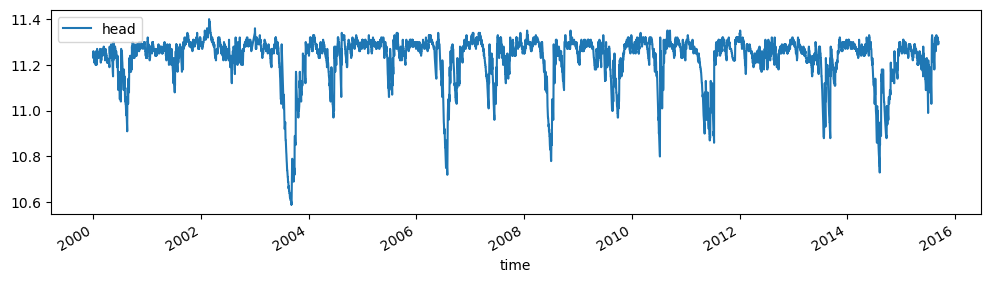

In [104]:
# visualize heads data
df_y.plot(figsize=(12,3))
plt.show()

In [138]:
# create 'day' feature
def create_features(df):
    #df['year'] = df.index.year
    #df['month'] = df.index.month
    df['day'] = df.index.day
    #df['dayofweek'] = df.index.day_of_week
    #df['quarter'] = df.index.quarter
    return(df)

In [142]:
df_X = create_features(df_X)

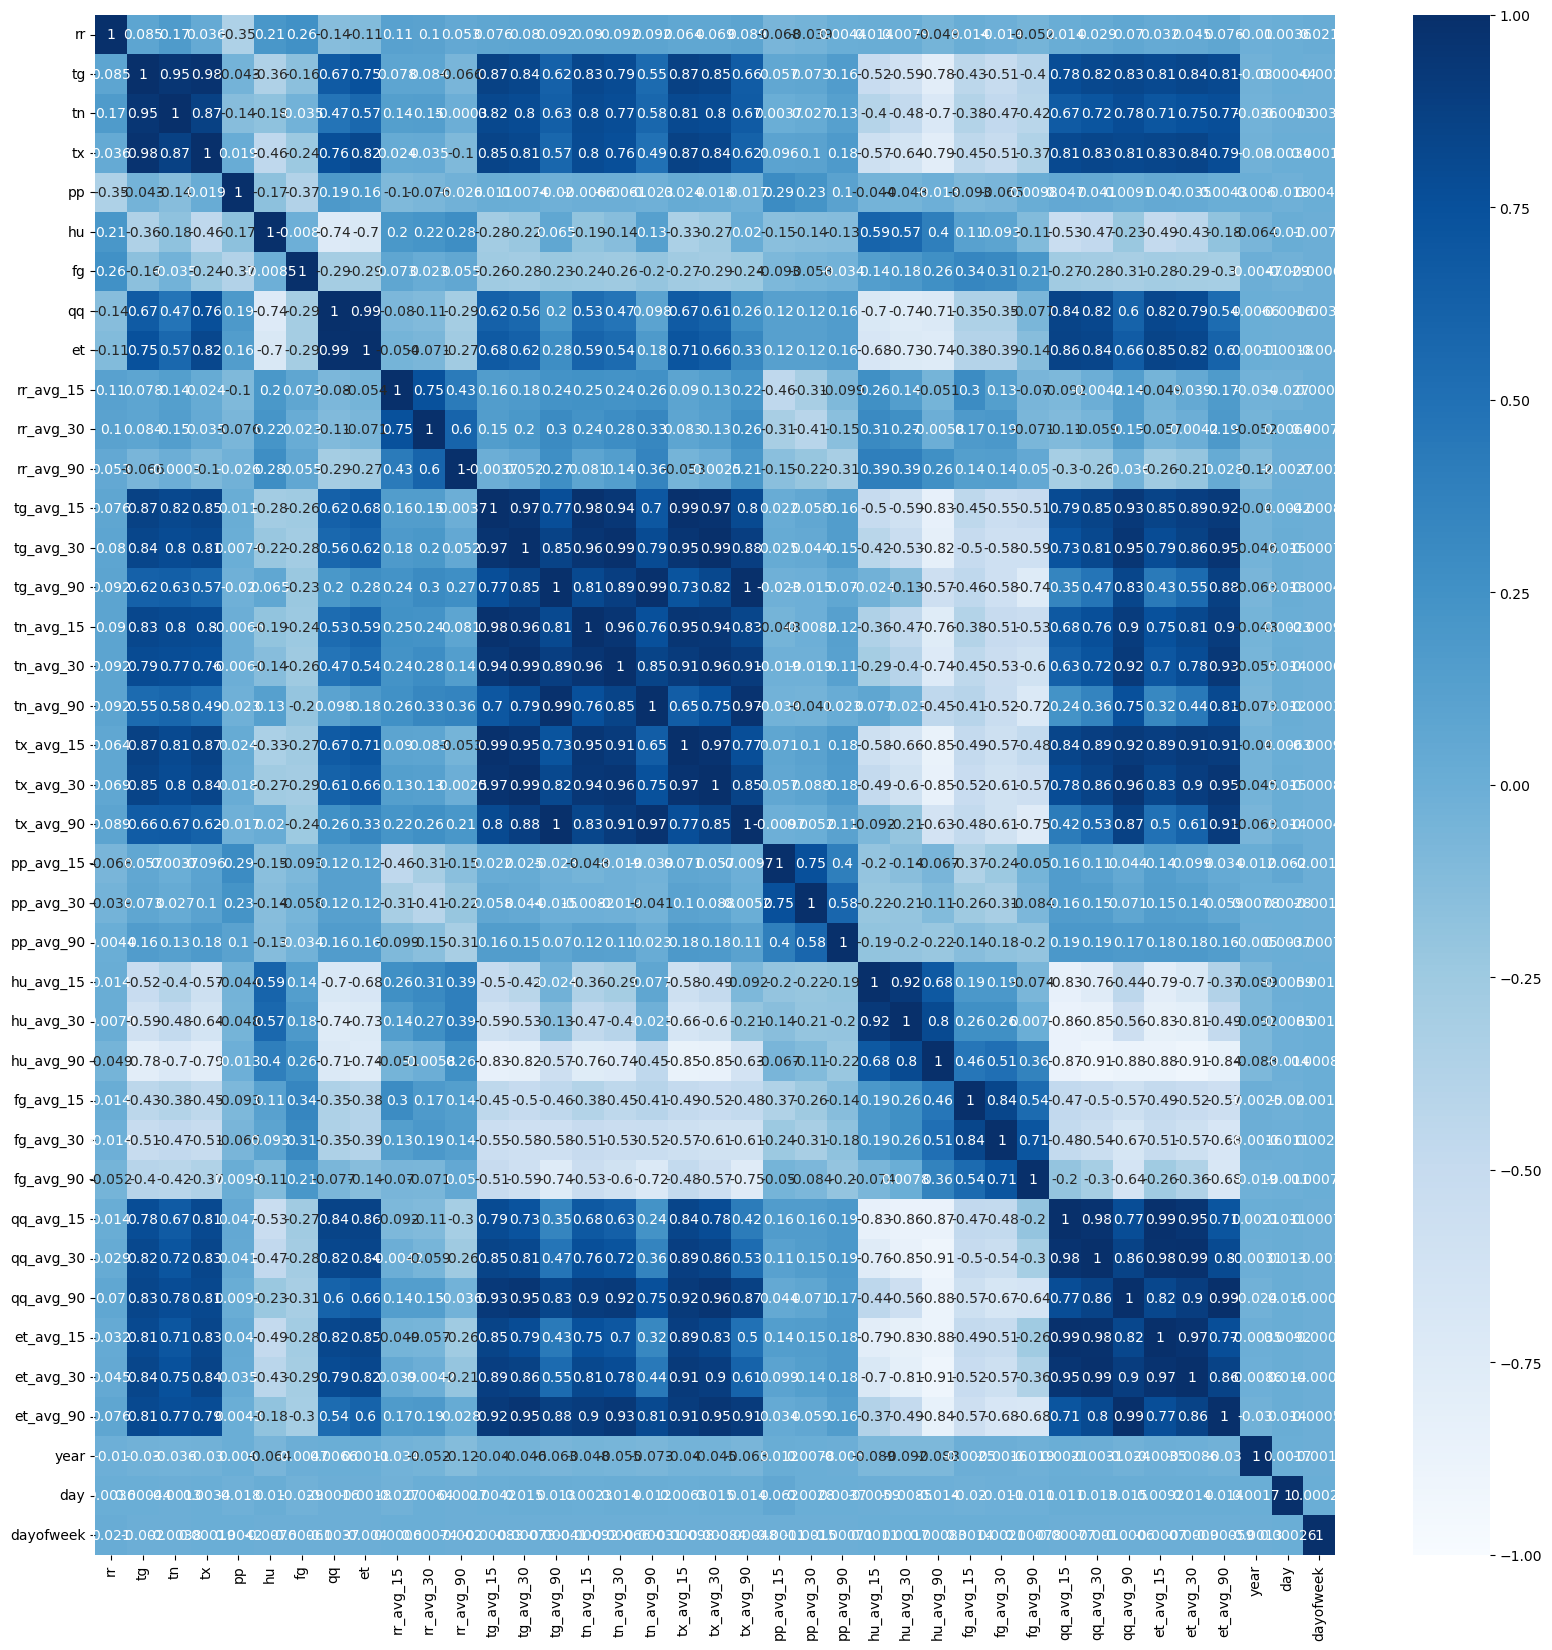

In [45]:
# check for multicolinearity
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

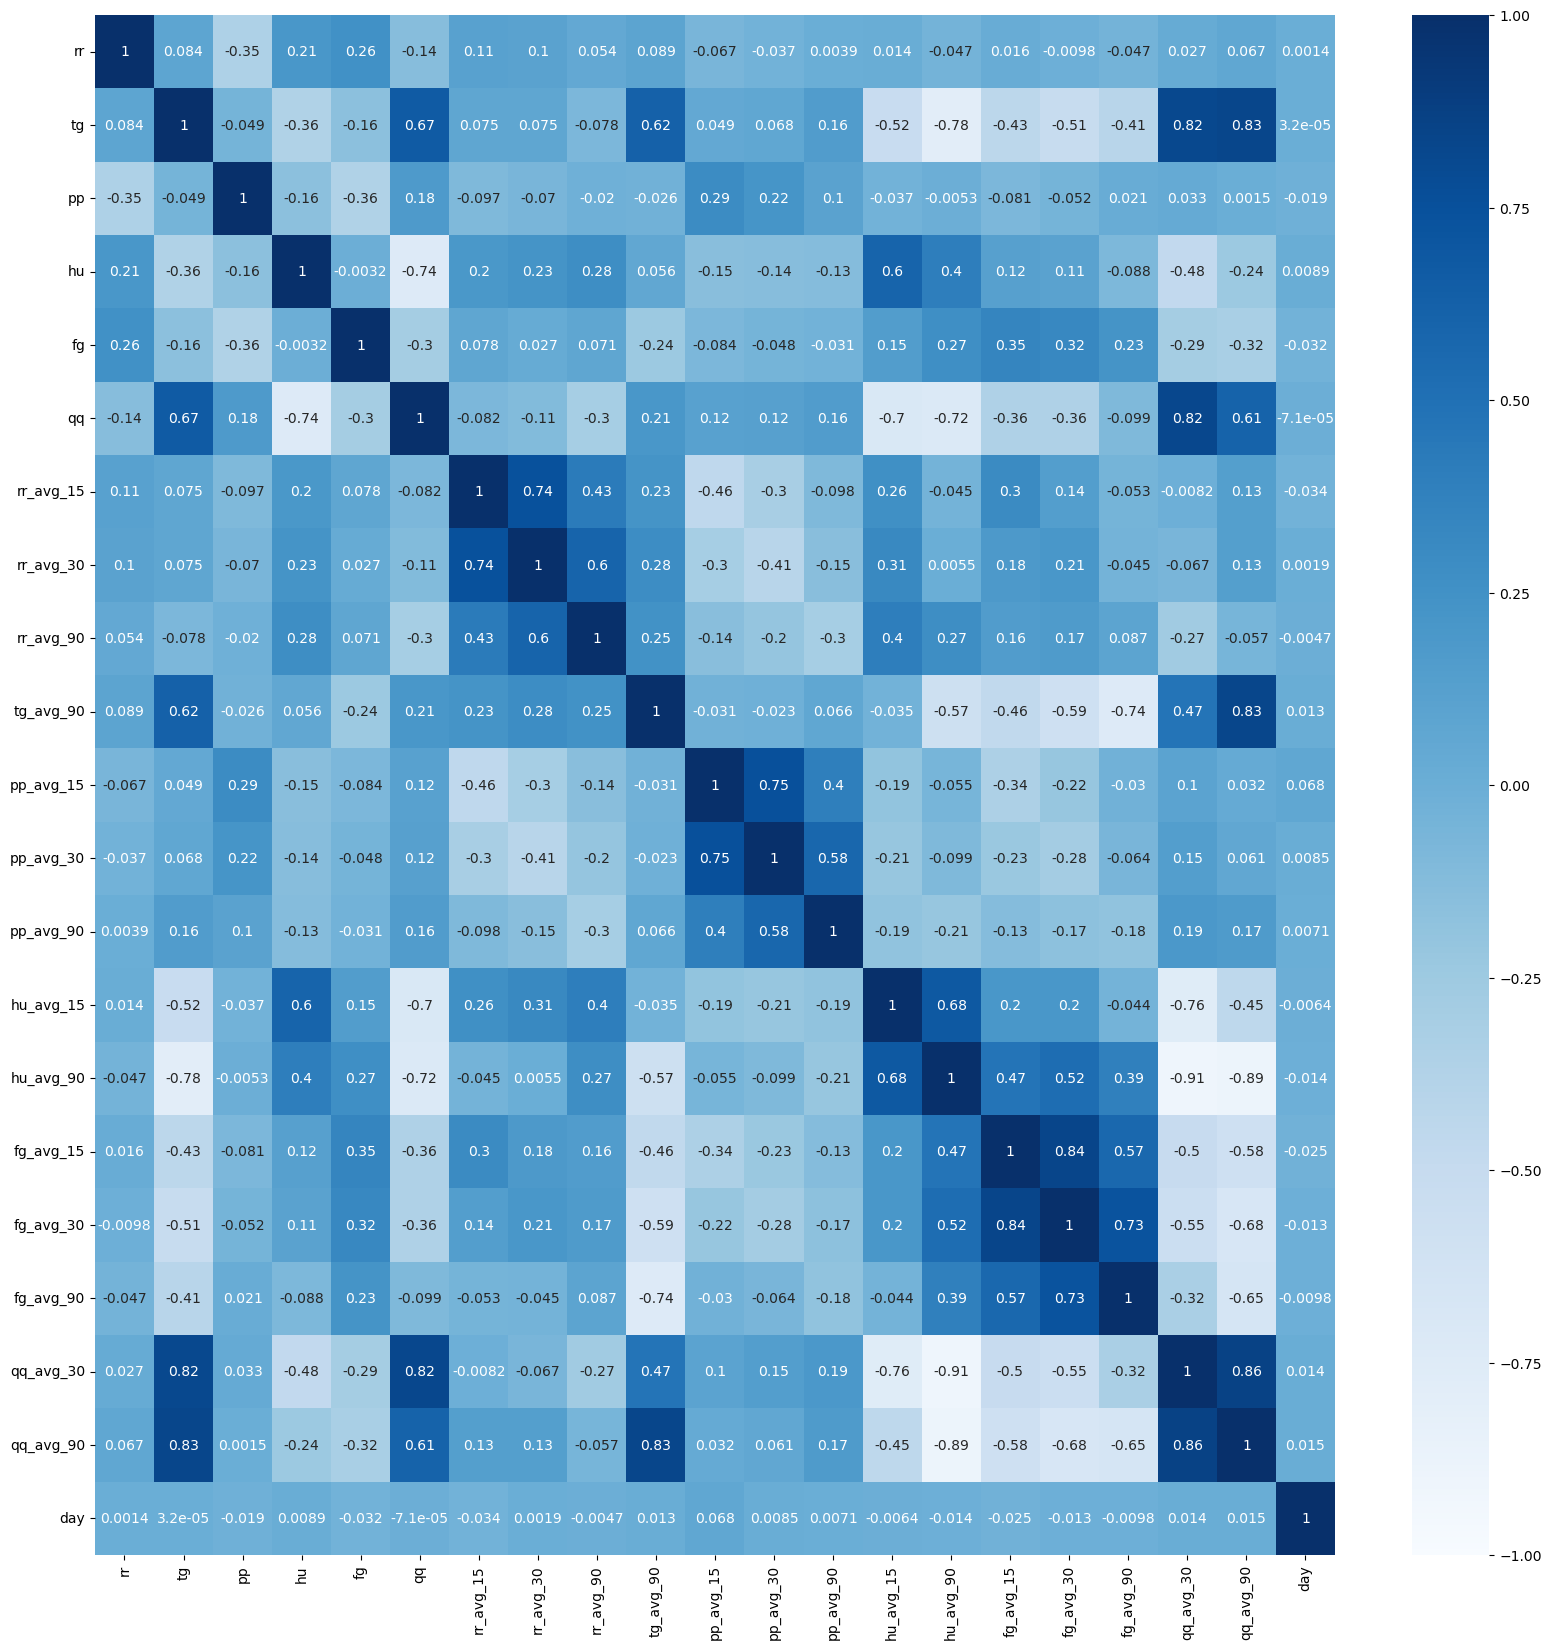

In [101]:
# drop highly correlated features
to_drop = ['tg_avg_15','tg_avg_30','hu_avg_30','qq_avg_15','qq_avg_15']
df_X = df_X.drop(columns=[col for col in df_X.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in to_drop)])
corr_matrix = df_X.corr()
plt.figure(figsize=(20,20))
# remember to always set the min max values! otherwise will be misleading
sns.heatmap(corr_matrix, cmap='Blues',vmin=-1,vmax=1, annot=True) 
plt.show()

### baseline predction score:

In [67]:
# split
df_y_train = df_y[df_y.index < '2012-01-01']
df_y_val = df_y[df_y.index >= '2012-01-01']

base_y_train = df_y_train
base_y_val = df_y_val

In [68]:
# calculate baseline RMSE
from sklearn.metrics import mean_squared_error

base_y_train['year'] = df_y_train.index.year
base_y_train['month'] = df_y_train.index.month
base_y_train['day'] = df_y_train.index.day

base_prediction = base_y_train.groupby(['month','day'])['head'].mean().reset_index()

base_y_val = df_y_val
base_y_val['month'] = df_y_val.index.month
base_y_val['day'] = df_y_val.index.day

base_y_val = pd.merge(base_y_val, base_prediction, on=['month','day'], how='left')
base_y_val.rename(columns={'head_x':'head_true','head_y':'head_pred'}, inplace=True)

baseline_RMSE = mean_squared_error(base_y_val['head_true'],base_y_val['head_pred'])

/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_54220/2113514236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_y_train['year'] = df_y_train.index.year
/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_54220/2113514236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_y_train['month'] = df_y_train.index.month
/var/folders/3h/rwm3946s6m393kd1m_w94xl00000gn/T/ipykernel_54220/2113514236.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [31]:
baseline_RMSE

0.007913267647156911

## Model Training:

### machine learning pipline:

In [105]:
# The function which takes the unprocessed feature matrix, target variable, 
# a preprocessor (ColumnTransformer), an uninitialized ML algorithm, 
# and a correspondig parameter grid as inputs.
# outputs the best models and their corresponding MSE scores on the test sets
def MLpipe_Multisplit_KFold_MSE(ColumnTransformer, ML_algorithm, parameter_grid):
    
    preprocessor = ColumnTransformer

    prep = Pipeline(steps=[('preprocessor', preprocessor)]) 
    param_grid = parameter_grid 
    
    nr_states = 5 # number of random states
    test_scores = np.zeros(nr_states)
    final_models = []

    base_train_year = 2011
    
    for i in range(nr_states):
        
        # split data into other and test set
        split_year = base_train_year + i
        split_date = '{}-01-01'.format(split_year)
        test_end_date = '{}-01-01'.format(split_year+1)
        print('split_year: ', split_year)

        feature_matrix_other=df_X[df_X.index<split_date]
        feature_matrix_test=df_X[(df_X.index>=split_date) & (df_X.index < test_end_date)]
        target_variable_other_df=df_y[df_y.index<split_date]
        target_variable_test_df=df_y[(df_y.index>=split_date) & (df_y.index < test_end_date)]

        target_variable_other=target_variable_other_df.values.ravel()
        target_variable_test=target_variable_test_df.values.ravel()

        #split other using time series splitting, used during cross validation
        tsp = TimeSeriesSplit(n_splits=4)

        # initialize the algorithm
        if ML_algorithm in [SVR, KNeighborsRegressor]:
            clf = ML_algorithm()
        else:
            clf = ML_algorithm(random_state = 42*i) 
        
        # make pipeline, steps include: preprocessing and training the ML algorithm
        pipe = make_pipeline(preprocessor,clf)

        # use GridSearchCV to tune hyperparameters
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'neg_mean_squared_error',
                            cv=tsp, return_train_score = True, n_jobs=-1, verbose=True)
        
        # fit the model on other
        grid.fit(feature_matrix_other, target_variable_other)
        # save results into a data frame.
        results = pd.DataFrame(grid.cv_results_)
        #print(results)

        print('best model parameters:',grid.best_params_)
        #print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
        final_models.append(grid)
        
        # calculate and save the test score
        target_variable_test_pred = final_models[-1].predict(feature_matrix_test)
        test_scores[i] = mean_squared_error(target_variable_test,target_variable_test_pred) #use MSE as test score
        std_test = np.std(target_variable_test_pred)
        print('test score:',test_scores[i])
        
        # train set plot
        target_variable_other_pred = final_models[-1].predict(feature_matrix_other)
        prediction = pd.DataFrame(target_variable_other_pred,index=target_variable_other_df.index)
        ax = target_variable_other_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        plt.legend(["train_data","predict"])
        plt.title("trainset plot")
        plt.show()
        
        # test set plot
        prediction = pd.DataFrame(target_variable_test_pred,index=target_variable_test_df.index)
        ax = target_variable_test_df.plot(figsize=(10,6))
        prediction.plot(ax=ax)
        plt.title("testset plot")
        plt.show()
    
    # print out mean of test scores
    print('mean of test scores:',np.mean(test_scores))
    #print('standard deviation of test scores:',np.std(test_scores))
    
    return test_scores, final_models

In [91]:
df_X.shape, df_y.shape

((5018, 22), (5606, 1))

split_year:  2011
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.005207625538641329


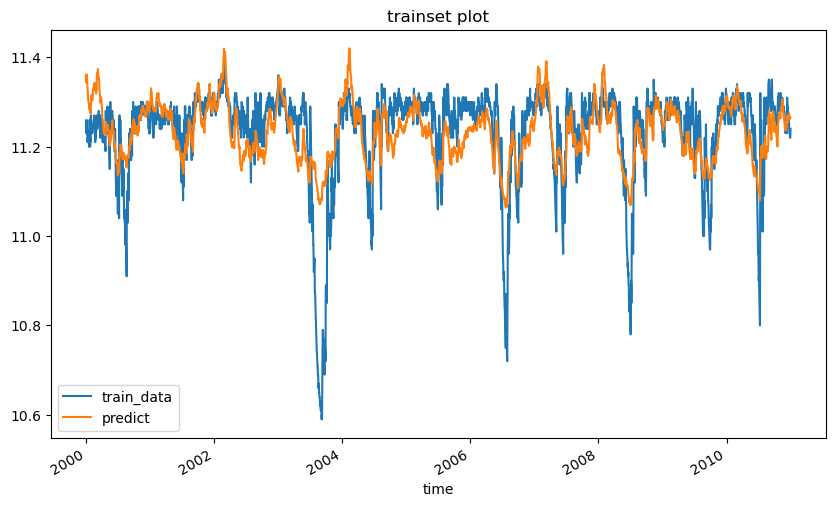

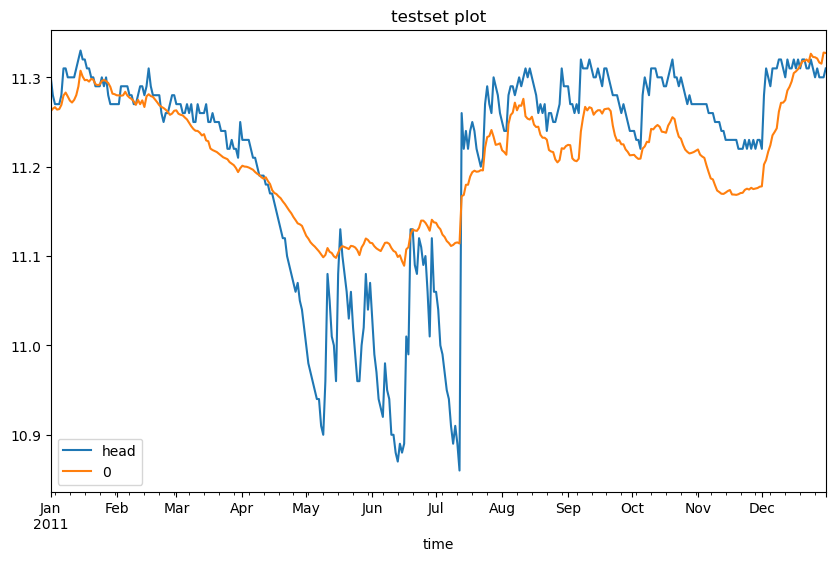

split_year:  2012
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.0025083897343641313


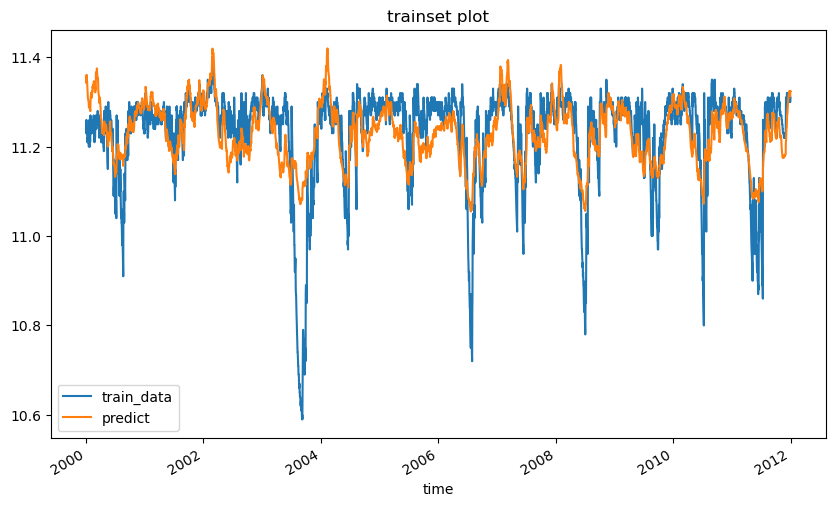

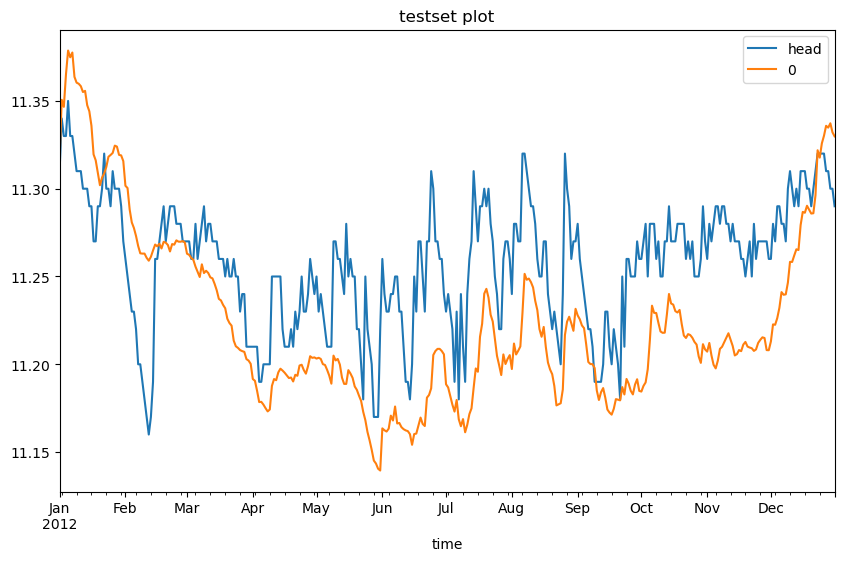

split_year:  2013
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.005188811776209596


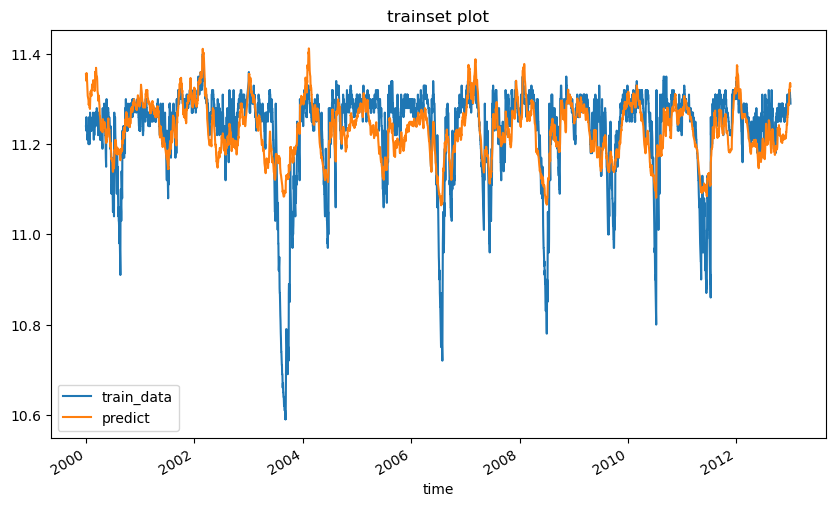

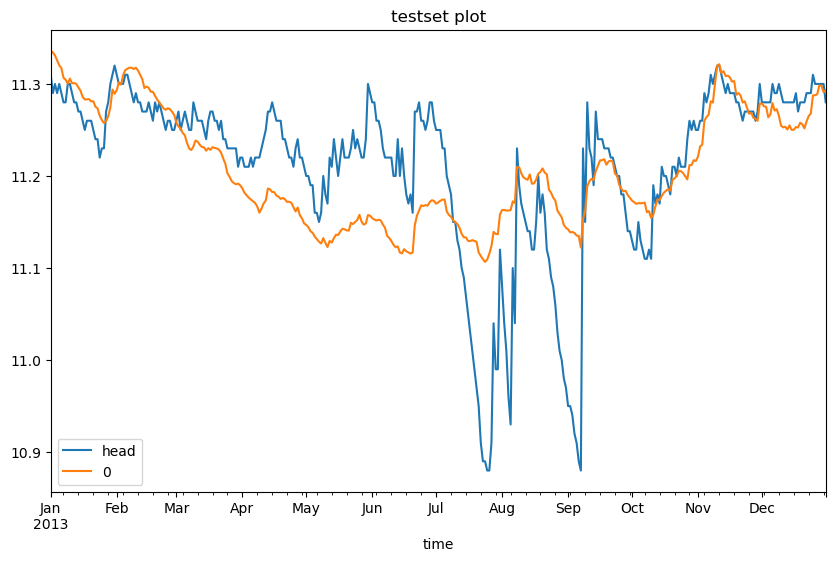

split_year:  2014
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.012717598668455775


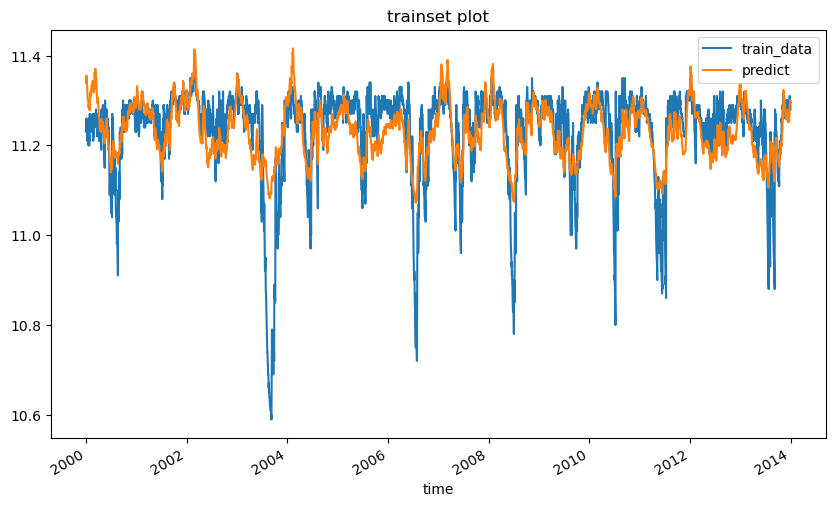

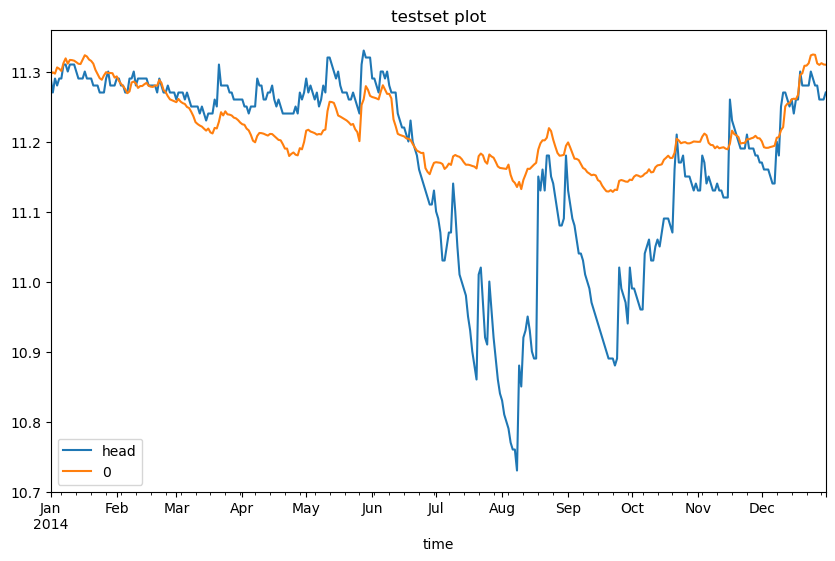

split_year:  2015
Fitting 4 folds for each of 11 candidates, totalling 44 fits
best model parameters: {'lasso__alpha': 0.01}
test score: 0.001886418413300667


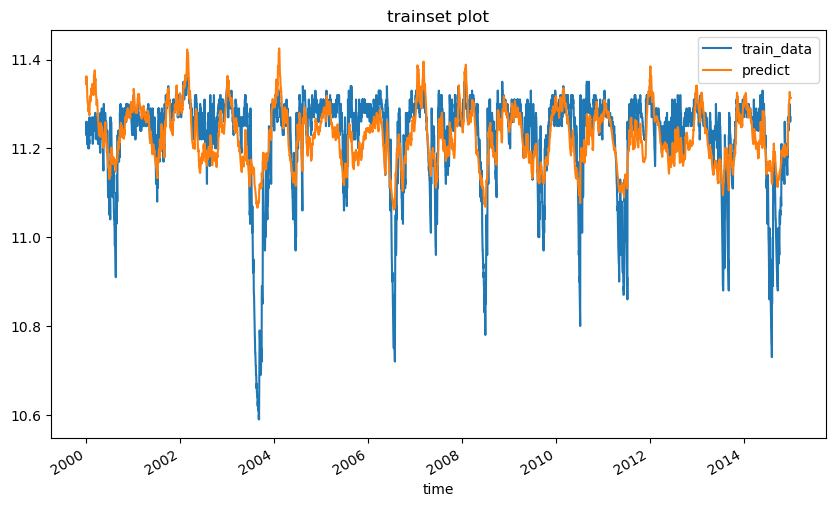

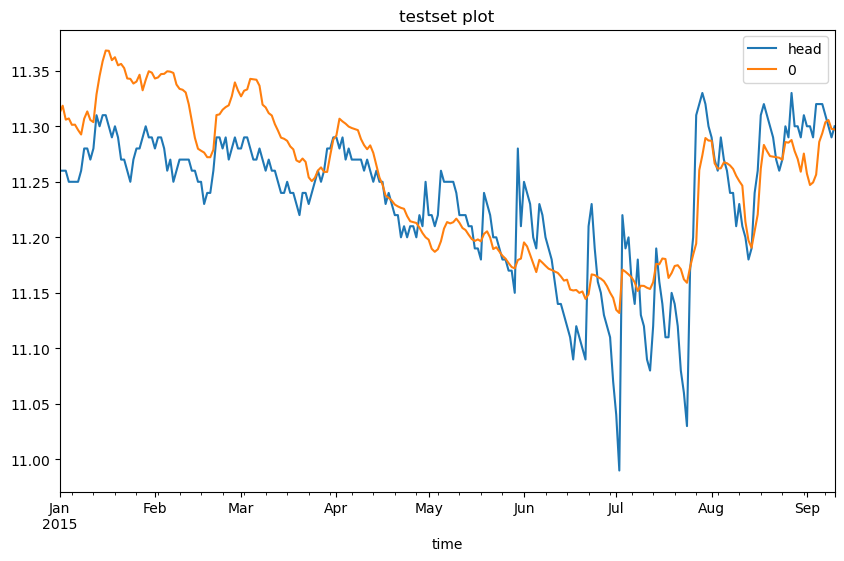

mean of test scores: 0.005501768826194299


In [106]:
# lasso regression
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]

columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), 
                                                   onehot_ftrs),('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=Lasso
parameter_grid = {'lasso__alpha': np.logspace(-2,2,11)} 

lasso_test_scores, lasso_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)

split_year:  2011
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.01}
test score: 0.0022775460429921633


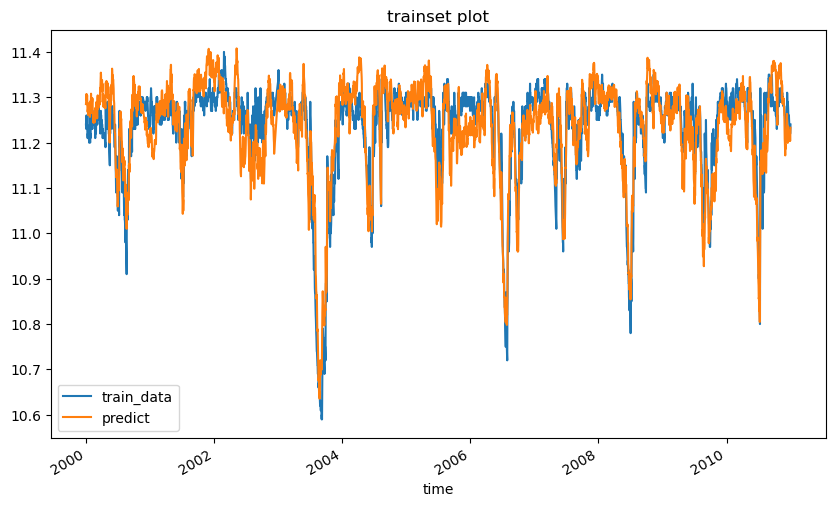

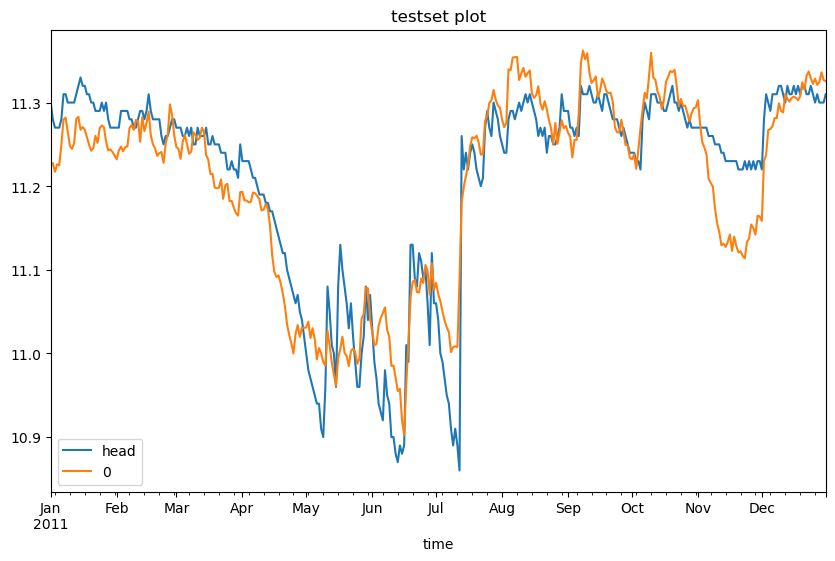

split_year:  2012
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.01}
test score: 0.0025989963870391222


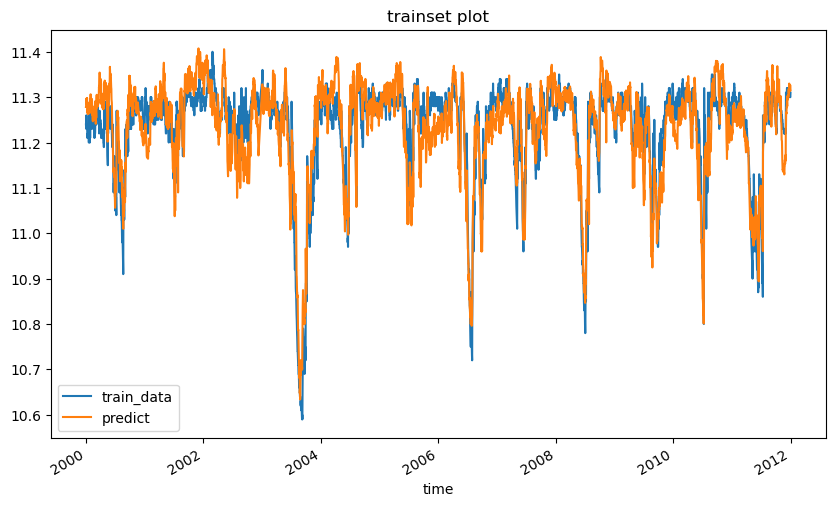

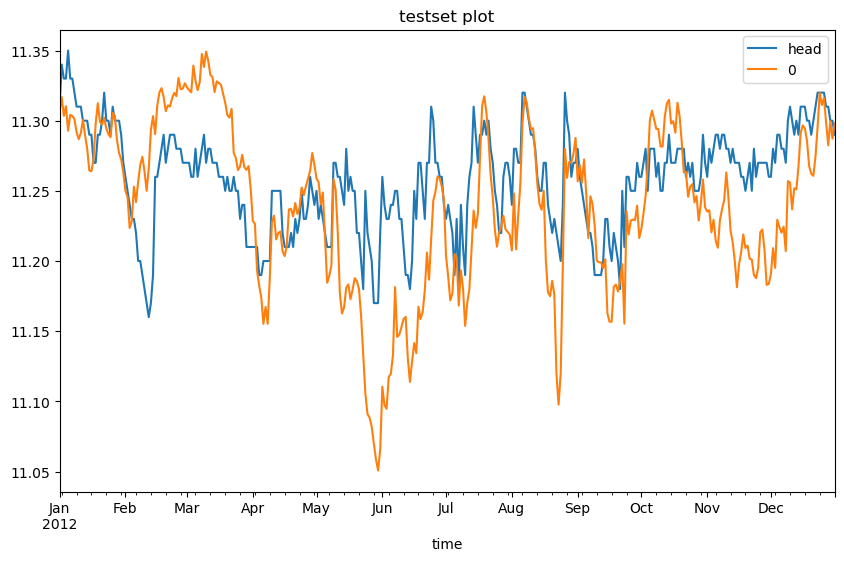

split_year:  2013
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.01}
test score: 0.0016302723164138568


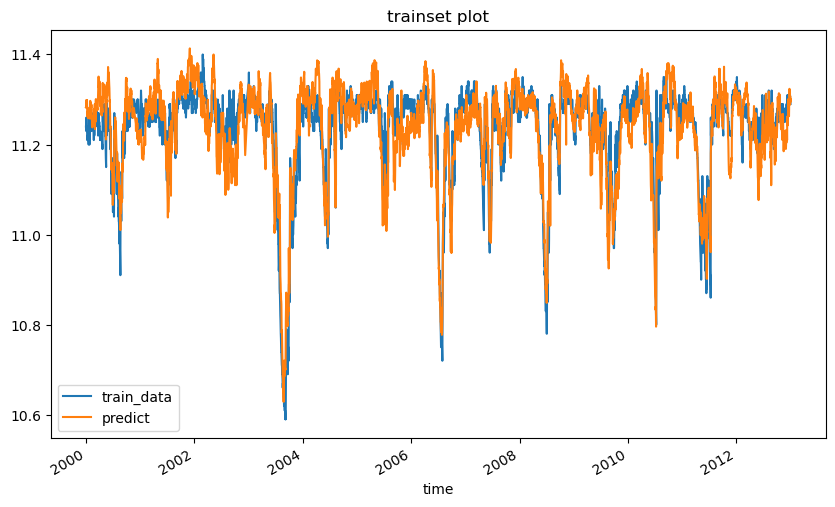

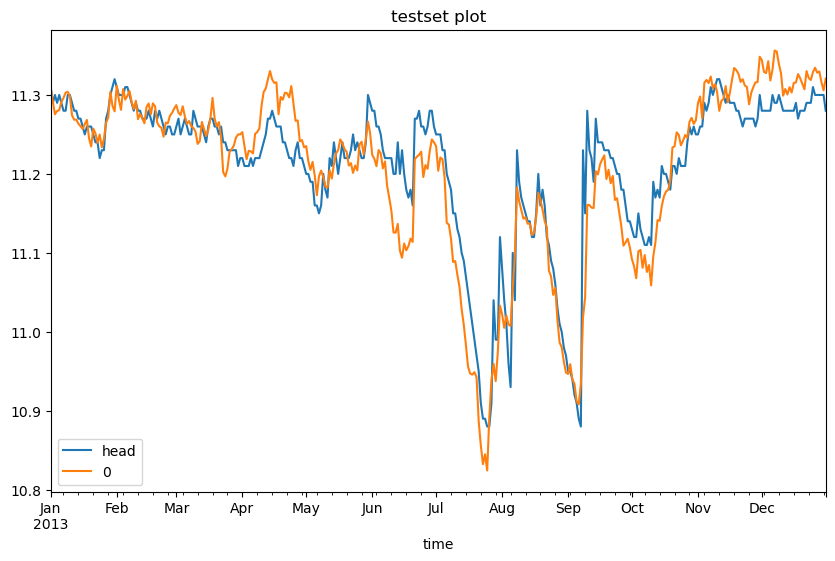

split_year:  2014
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.01}
test score: 0.005954967597954957


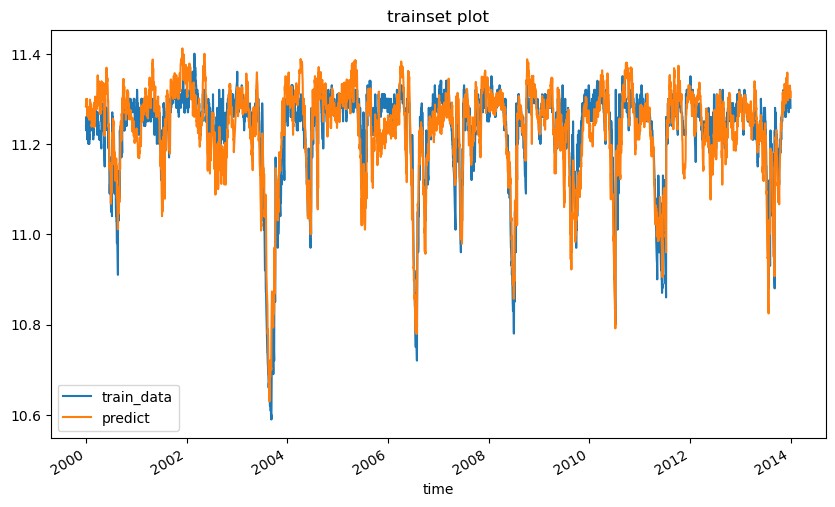

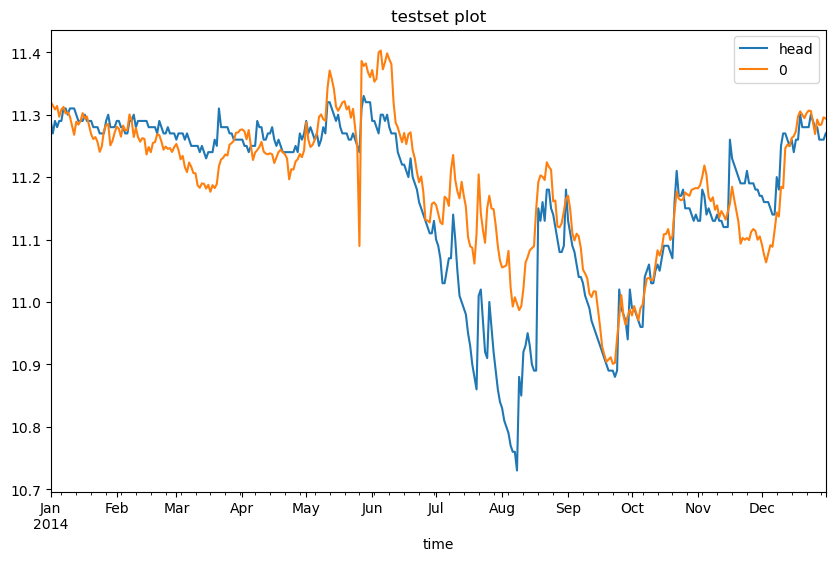

split_year:  2015
Fitting 4 folds for each of 15 candidates, totalling 60 fits
best model parameters: {'svr__C': 1.0, 'svr__gamma': 0.01}
test score: 0.004664777500339892


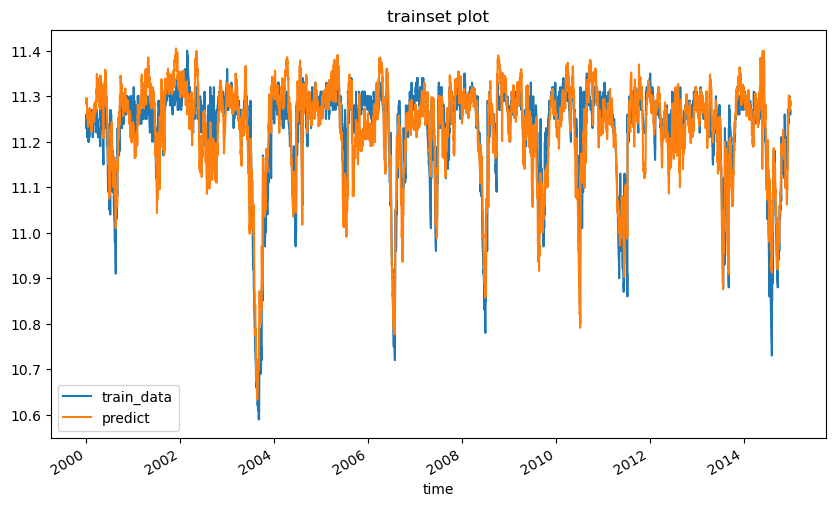

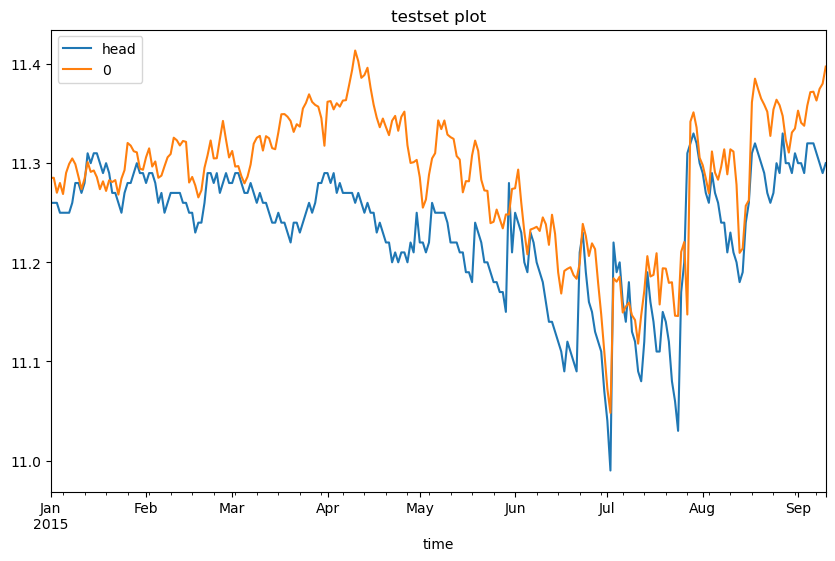

mean of test scores: 0.0034253119689479986
140.9923870563507


In [110]:
# SVR
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=SVR
parameter_grid = {'svr__gamma': [1e-2, 1e-1, 1e1, 1e2, 1e3],'svr__C': [1e-1, 1e0, 1e1]} 

start_time = time.time()
SVR_test_scores, SVR_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)
end_time = time.time()
SVR_runtime = end_time-start_time
print(SVR_runtime)

split_year:  2011
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 30, 'randomforestregressor__max_features': 0.75}
test score: 0.0028737988074276554


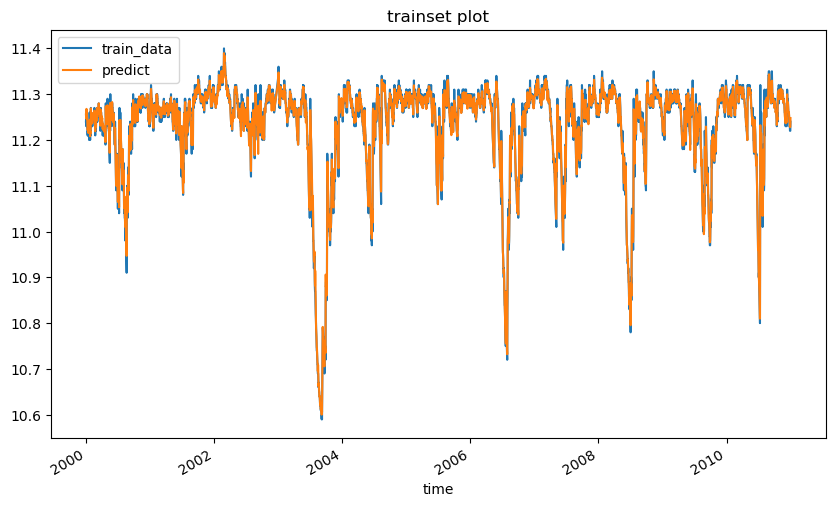

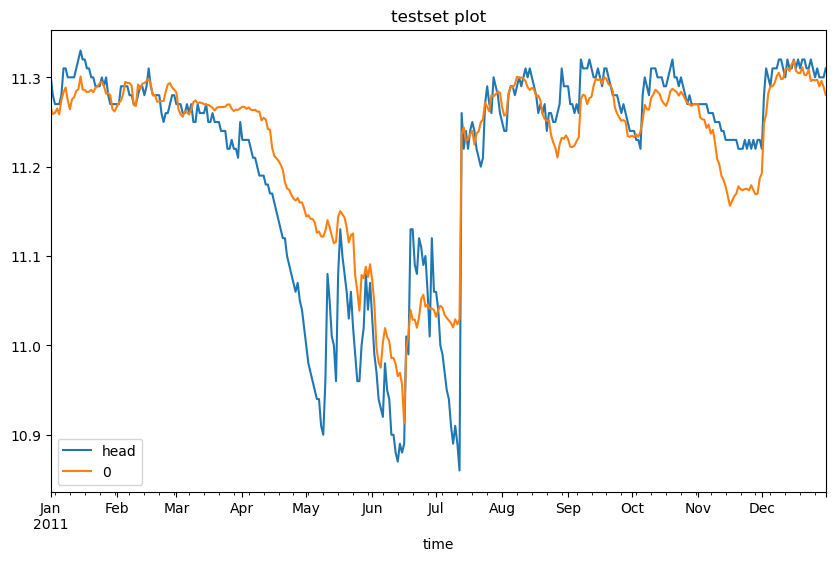

split_year:  2012
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 0.5}
test score: 0.0009529233333333946


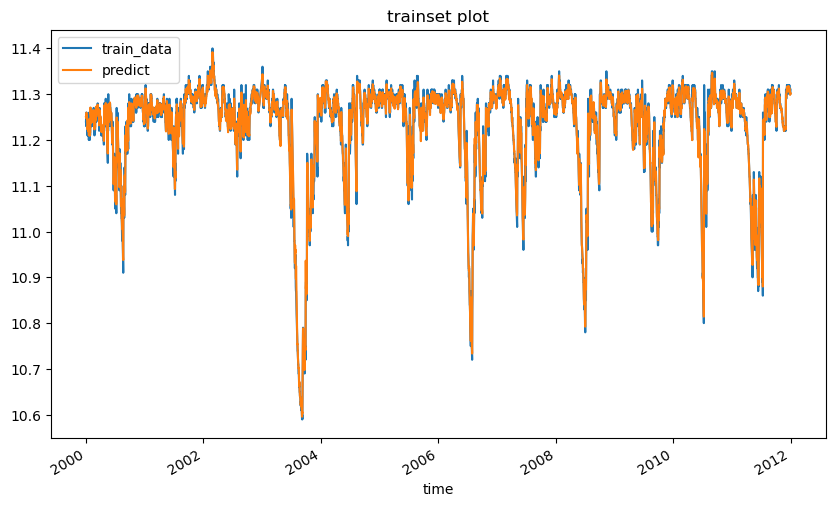

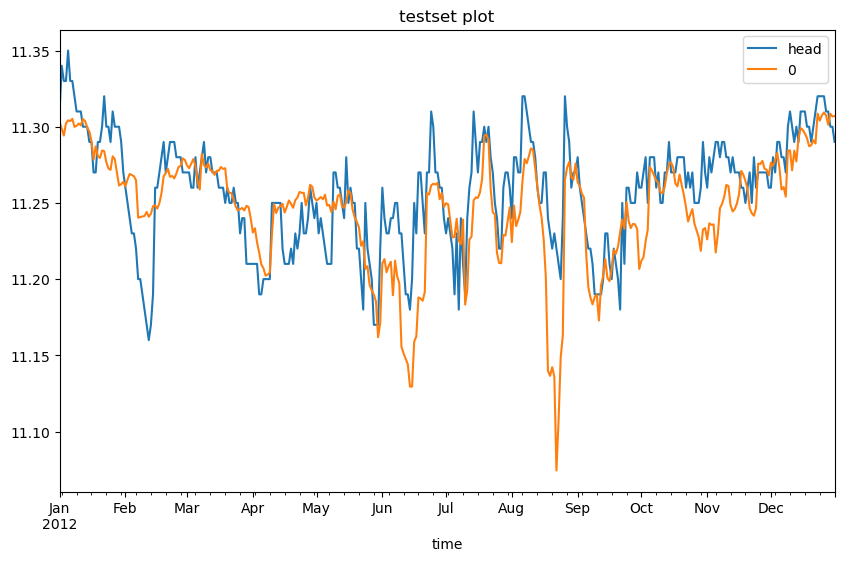

split_year:  2013
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.25}
test score: 0.001467645496444505


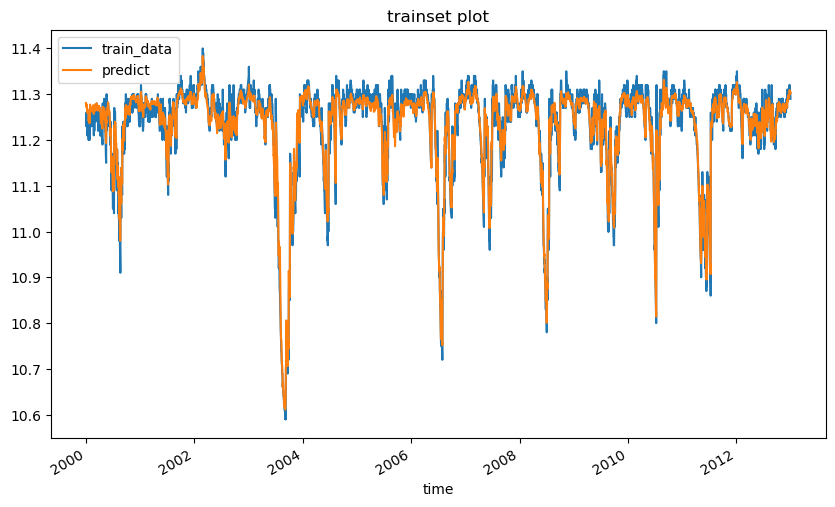

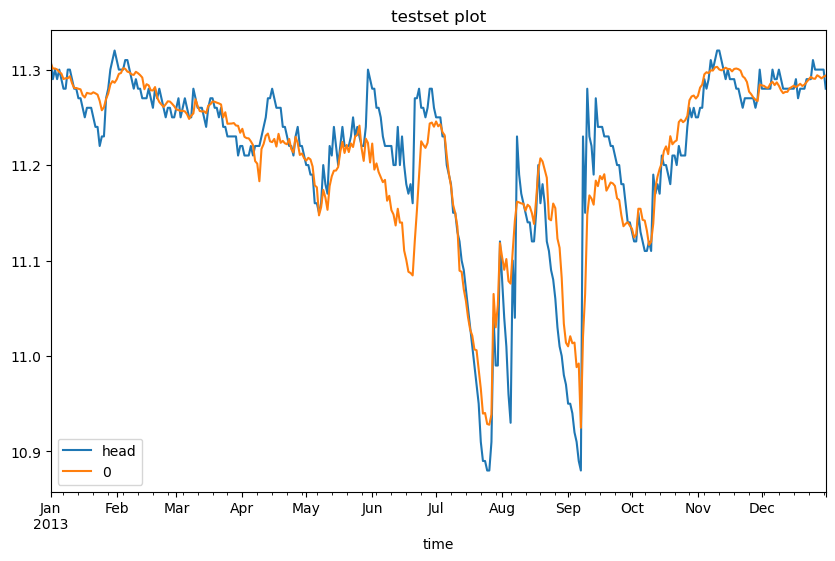

split_year:  2014
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.75}
test score: 0.008056141025553387


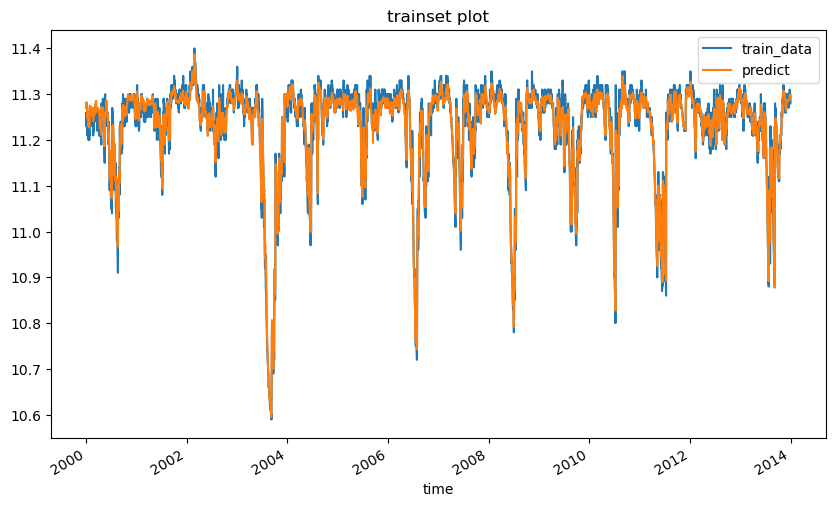

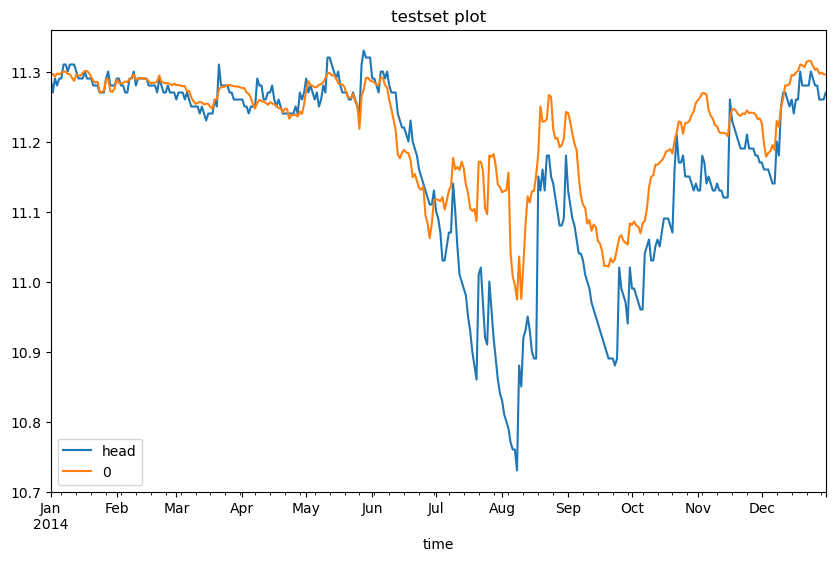

split_year:  2015
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 50, 'randomforestregressor__max_features': 0.5}
test score: 0.0016527772727270508


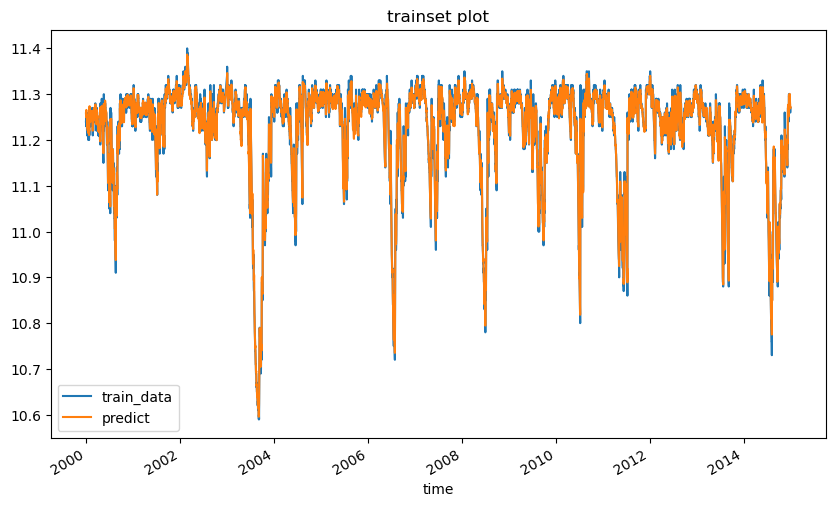

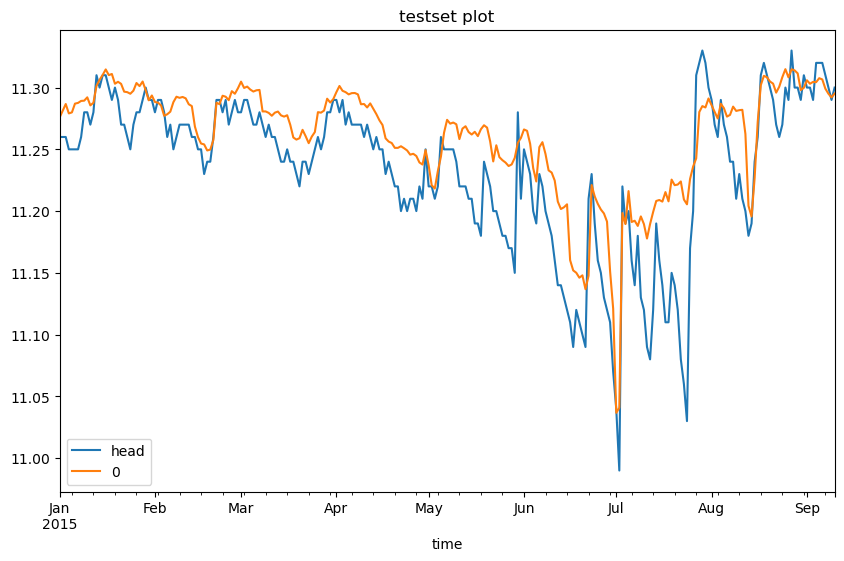

mean of test scores: 0.0030006571870971983
284.6726930141449


In [111]:
# random forest
onehot_ftrs = ['day']
std_ftrs = [col for col in df_X.columns if col not in onehot_ftrs]
columnTransformer=ColumnTransformer(transformers=[('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'), onehot_ftrs),
                                                  ('std', StandardScaler(), std_ftrs)],remainder='passthrough')
ML_algorithm=RandomForestRegressor
parameter_grid = {'randomforestregressor__max_depth': [1,5,10,30,50,100],'randomforestregressor__max_features': [0.01,0.25,0.5,0.75,1]} 

start_time = time.time()
rf_test_scores, rf_models = MLpipe_Multisplit_KFold_MSE(columnTransformer, ML_algorithm, parameter_grid)
end_time = time.time()
rf_runtime = end_time-start_time
print(rf_runtime)

## Model results:
the SVR model was chosen as the best model because it has a similar mean MSE as the random forest model, but its MSE has a lower standard deviation and training an SVR model taks only around half the amount of time it takes to train a random forest model.

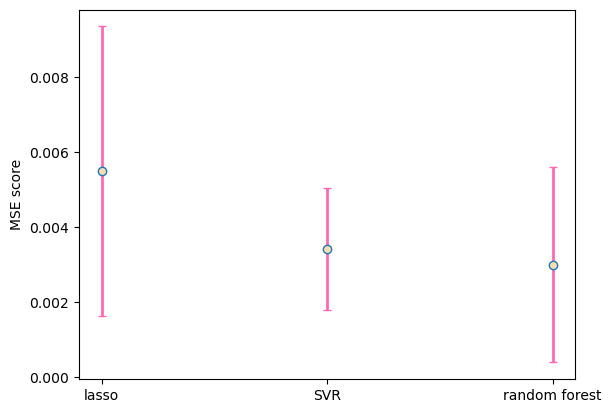

In [112]:
lasso_mean = np.mean(lasso_test_scores)
lasso_std = np.std(lasso_test_scores)

SVR_mean = np.mean(SVR_test_scores)
SVR_std = np.std(SVR_test_scores)

rf_mean = np.mean(rf_test_scores)
rf_std = np.std(rf_test_scores)

plt.errorbar(['lasso','SVR','random forest'],[lasso_mean,SVR_mean,rf_mean], yerr=[lasso_std,SVR_std,rf_std],ecolor="hotpink",fmt="o",elinewidth=2,mfc="wheat",capsize=3)
plt.ylabel('MSE score')
plt.show()

In [162]:
# save the 5 SVR models
import pickle
for i in range(5):
    model = SVR_models[i]
    filename = 'netherlands_models/SVR_model_{}.sav'.format(i)
    pickle.dump(model, open(filename, 'wb'))


## Predict on submission test data

In [152]:
# preprocess input data and add features
df_input = df_input.set_index('time')
df_input.index = pd.to_datetime(df_input.index)
df_input.index = df_input.index.rename("time")
df_input = create_features(df_input)
df_input = df_input.drop(columns=[col for col in df_input.columns if (col.startswith('tn') or col.startswith('tx') or col.startswith('et') or col in to_drop)])
df_input

rr         tg          pp         hu    fg     qq  rr_avg_15  \
time                                                                        
1990-04-01  0.0  11.679999  1021.20000  77.020004  2.63  202.0   1.253333   
1990-04-02  2.8  12.660000  1002.90000  68.780000  5.17  180.0   1.253333   
1990-04-03  2.9   6.430000   999.30000  80.690000  6.66  118.0   1.440000   
1990-04-04  1.6   3.280000  1012.70000  81.275000  4.97  158.0   1.386667   
1990-04-05  0.0   2.560000  1019.80000  80.490000  2.10  183.0   1.493333   
...         ...        ...         ...        ...   ...    ...        ...   
2021-12-27  0.0   2.110000   998.70000  92.220000  3.13   20.0   0.960000   
2021-12-28  5.5   6.610000   990.40000  93.700005  3.36   23.0   0.780000   
2021-12-29  4.0   7.030000  1001.30000  93.700005  2.99   21.0   1.146667   
2021-12-30  4.4  11.370000  1013.10004  92.500010  3.85   18.0   1.360000   
2021-12-31  9.1  12.799999  1018.40000  86.878950  3.85   21.0   1.653333   

            rr_avg_30  rr_avg_90  tg_avg_90  ...    pp_avg_30    pp_avg_90  \
time                                         ...                             
1990-04-01   1.090000   2.282222   6.462333  ...  1024.883343  1015.855565   
1990-04-02   1.036667   2.282222   6.611111  ...  1024.820009  1015.862231   
1990-04-03   1.130000   2.313333   6.759111  ...  1023.676672  1015.646676   
1990-04-04   1.226667   2.345556   6.830000  ...  1022.526672  1015.371120   
1990-04-05   1.146667   2.335556   6.869667  ...  1022.163337  1015.272231   
...               ...        ...        ...  ...          ...          ...   
2021-12-27   1.820000   2.440000   7.931555  ...  1012.563339  1015.104452   
2021-12-28   1.680000   2.440000   7.811778  ...  1012.866671  1014.876674   
2021-12-29   1.863333   2.326667   7.764111  ...  1012.693336  1014.576674   
2021-12-30   1.950000   2.371111   7.710444  ...  1012.556669  1014.358897   
2021-12-31   1.780000   2.355556   7.690667  ...  1012.940003  1014.358897   

            hu_avg_15  hu_avg_90  fg_avg_15  fg_avg_30  fg_avg_90   qq_avg_30  \
time                                                                            
1990-04-01  81.436334  86.530844   4.604667   5.527000   6.109555  103.666667   
1990-04-02  81.428668  86.352594   4.600667   5.415333   6.113000  107.133333   
1990-04-03  81.850001  86.094001   4.740000   5.391333   6.146778  110.300000   
1990-04-04  82.007668  85.974007   4.779333   5.348000   6.178667  112.600000   
1990-04-05  81.791668  85.838253   4.850667   5.184333   6.190444  116.766667   
...               ...        ...        ...        ...        ...         ...   
2021-12-27  89.250094  88.660406   3.000000   3.214333   3.439000   24.666667   
2021-12-28  89.068093  88.752740   2.965333   3.225333   3.441111   24.366667   
2021-12-29  89.215786  88.788997   2.996000   3.256667   3.432000   24.266667   
2021-12-30  89.210601  88.989886   3.004000   3.265333   3.403889   23.966667   
2021-12-31  89.347268  89.108330   3.049333   3.257667   3.385111   23.900000   

            qq_avg_90  day  
time                        
1990-04-01  57.300000    1  
1990-04-02  59.444444    2  
1990-04-03  61.322222    3  
1990-04-04  62.500000    4  
1990-04-05  64.144444    5  
...               ...  ...  
2021-12-27  44.266667   27  
2021-12-28  42.900000   28  
2021-12-29  42.477778   29  
2021-12-30  41.544444   30  
2021-12-31  40.911111   31  

[11598 rows x 21 columns]

In [160]:
submission_X = df_input[(df_input.index>='2000-01-01')]
submission_X

rr         tg          pp         hu    fg    qq  \
time                                                                  
2000-01-01   0.000000   4.110000  1022.80000  94.596300  3.38  14.0   
2000-01-02   0.000000   6.150000  1025.70010  93.992600  4.33  10.0   
2000-01-03  14.900001   8.160000  1018.20000  93.388890  6.76   8.0   
2000-01-04   3.600000   4.810000  1013.30000  94.700005  4.12  10.0   
2000-01-05   0.000000   3.960000  1017.60004  90.840004  4.78  36.0   
...               ...        ...         ...        ...   ...   ...   
2021-12-27   0.000000   2.110000   998.70000  92.220000  3.13  20.0   
2021-12-28   5.500000   6.610000   990.40000  93.700005  3.36  23.0   
2021-12-29   4.000000   7.030000  1001.30000  93.700005  2.99  21.0   
2021-12-30   4.400000  11.370000  1013.10004  92.500010  3.85  18.0   
2021-12-31   9.100000  12.799999  1018.40000  86.878950  3.85  21.0   

            rr_avg_15  rr_avg_30  rr_avg_90  tg_avg_90  ...    pp_avg_30  \
time                                                    ...                
2000-01-01   4.153333   5.696667   3.047778   6.654778  ...  1005.523337   
2000-01-02   3.766667   5.536667   2.990000   6.589333  ...  1005.800004   
2000-01-03   3.566667   5.120000   2.917778   6.540889  ...  1006.620006   
2000-01-04   4.046667   5.460000   3.075556   6.522778  ...  1007.086673   
2000-01-05   4.286667   5.496667   3.115556   6.465111  ...  1006.906673   
...               ...        ...        ...        ...  ...          ...   
2021-12-27   0.960000   1.820000   2.440000   7.931555  ...  1012.563339   
2021-12-28   0.780000   1.680000   2.440000   7.811778  ...  1012.866671   
2021-12-29   1.146667   1.863333   2.326667   7.764111  ...  1012.693336   
2021-12-30   1.360000   1.950000   2.371111   7.710444  ...  1012.556669   
2021-12-31   1.653333   1.780000   2.355556   7.690667  ...  1012.940003   

              pp_avg_90  hu_avg_15  hu_avg_90  fg_avg_15  fg_avg_30  \
time                                                                  
2000-01-01  1013.827786  90.618858  89.189862   5.122000   5.887333   
2000-01-02  1014.083341  90.792315  89.241166   4.784000   5.740667   
2000-01-03  1014.270009  91.323155  89.309028   4.808667   5.515000   
2000-01-04  1014.246676  91.333525  89.405460   5.006667   5.528667   
2000-01-05  1014.110009  91.586025  89.477071   5.050667   5.522000   
...                 ...        ...        ...        ...        ...   
2021-12-27  1015.104452  89.250094  88.660406   3.000000   3.214333   
2021-12-28  1014.876674  89.068093  88.752740   2.965333   3.225333   
2021-12-29  1014.576674  89.215786  88.788997   2.996000   3.256667   
2021-12-30  1014.358897  89.210601  88.989886   3.004000   3.265333   
2021-12-31  1014.358897  89.347268  89.108330   3.049333   3.257667   

            fg_avg_90  qq_avg_30  qq_avg_90  day  
time                                              
2000-01-01   4.846555  18.866667  39.955556    1  
2000-01-02   4.817222  18.466667  39.233333    2  
2000-01-03   4.823889  18.500000  38.377778    3  
2000-01-04   4.857555  17.766667  37.333333    4  
2000-01-05   4.865555  16.866667  36.555556    5  
...               ...        ...        ...  ...  
2021-12-27   3.439000  24.666667  44.266667   27  
2021-12-28   3.441111  24.366667  42.900000   28  
2021-12-29   3.432000  24.266667  42.477778   29  
2021-12-30   3.403889  23.966667  41.544444   30  
2021-12-31   3.385111  23.900000  40.911111   31  

[8036 rows x 21 columns]

In [163]:
# using final models to create 5 predictions on the submission test set
predictions = []
for i in range(5):
    model = pickle.load(open('netherlands_models/SVR_model_{}.sav'.format(i), 'rb'))
    prediction = model.predict(submission_X)
    predictions.append(prediction)
predictions = np.array(predictions)

In [164]:
# calculate the mean and 95% confidence interval of the prediction
pred_std = np.mean(SVR_test_scores**0.5)
pred_mean = np.mean(predictions,axis=0)
upper = pred_mean + 1.96*pred_std
lower = pred_mean - 1.96*pred_std

In [166]:
full_sim_results = pd.DataFrame({'Date' : submission_X.index,
                                 'Simulated Head' : pred_mean,
                                 '95% Lower Bound' : lower,
                                 '95% Upper Bound' : upper
                                })
full_sim_results

Date  Simulated Head  95% Lower Bound  95% Upper Bound
0    2000-01-01       11.282421        11.170878        11.393964
1    2000-01-02       11.284795        11.173252        11.396338
2    2000-01-03       11.298657        11.187114        11.410199
3    2000-01-04       11.297638        11.186095        11.409181
4    2000-01-05       11.287504        11.175962        11.399047
...         ...             ...              ...              ...
8031 2021-12-27       11.260866        11.149323        11.372409
8032 2021-12-28       11.273055        11.161512        11.384598
8033 2021-12-29       11.282529        11.170986        11.394072
8034 2021-12-30       11.302071        11.190528        11.413614
8035 2021-12-31       11.301064        11.189522        11.412607

[8036 rows x 4 columns]

In [167]:
full_sim_results.to_csv('submissions/team_example/full_simulation_results_Netherlands.csv')

In [176]:
submission_form = pd.read_csv('submissions/team_example/submission_form_Netherlands.csv')

In [177]:
submission_form.drop(columns=['Simulated Head','95% Lower Bound','95% Upper Bound'], inplace=True)
submission_form['Date'] = submission_form['Date'].astype('datetime64')
submission_form = pd.merge(submission_form, full_sim_results, on='Date', how='left')
submission_form

Date  Simulated Head  95% Lower Bound  95% Upper Bound
0    2000-01-01       11.282421        11.170878        11.393964
1    2000-01-02       11.284795        11.173252        11.396338
2    2000-01-03       11.298657        11.187114        11.410199
3    2000-01-04       11.297638        11.186095        11.409181
4    2000-01-05       11.287504        11.175962        11.399047
...         ...             ...              ...              ...
7218 2020-11-23       11.283257        11.171714        11.394800
7219 2020-11-24       11.281057        11.169514        11.392600
7220 2020-11-25       11.277272        11.165729        11.388815
7221 2020-11-26       11.289881        11.178338        11.401423
7222 2020-11-27       11.277055        11.165512        11.388597

[7223 rows x 4 columns]

In [178]:
submission_form.to_csv('submissions/team_example/submission_form_Netherlands.csv')

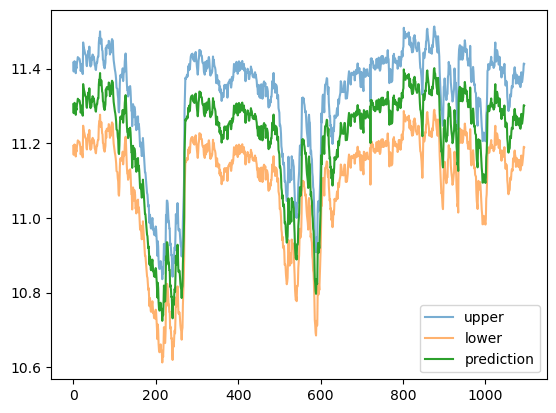

In [165]:
# visualize prediction
plt.plot(upper[-1095:],alpha=0.6,label='upper')
plt.plot(lower[-1095:],alpha=0.6,label='lower')
plt.plot(pred_mean[-1095:],label='prediction')
plt.legend()
plt.show()